<a href="https://colab.research.google.com/github/koliche/Arabic-Text-Classification/blob/main/Arabic_Text_Classification_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



> In this Arabic text classification project, we create a Lab that contain first data cleaning, tokenization, and convert text to numerical value. Second, four deep learning model for text classification without Keras Tuner, finally we add the Keras Tuner to deep learning models, and we specify the best model for Arabic text classification.

> The lab can be used for the three datasets Arabiya, Akhbarona, Khaleej. But the results below are Khaleej dataset result.

# **Load The Dataset**

> First, load and unzip the dataset then read it, in Khaleej dataset we have 7 classes and 45500 Arabic text files.



In [4]:
# !unzip Arabiya.zip -d /content/Arabiya/
# !unzip Akhbarona.zip -d /content/Akhbarona/
# !unzip Khaleej.zip -d /content/khaleej/

In [5]:
import os
import tensorflow as tf
import numpy as np


In [6]:
all_data = tf.keras.preprocessing.text_dataset_from_directory(
    '/content/khaleej',
    labels = "inferred",
    label_mode = "int",
    max_length = None,
    shuffle=True,
    seed=32,
    validation_split=None,
    subset=None,
)

Found 45500 files belonging to 7 classes.


In [7]:
all_data.class_names

['Culture', 'Finance', 'Medical', 'Politics', 'Religion', 'Sports', 'Tech']

In [8]:
# text is collected in to x, and the corresponding label names are collected in to y.
x=[]
y=[]
for text_batch, label_batch in all_data:
    for i in range(len(text_batch)):
        s=text_batch.numpy()[i].decode("utf-8") 
        x.append(s)
        y.append(all_data.class_names[label_batch.numpy()[i]])
print(len(x))
print(len(y))

45500
45500


In [9]:
x[:1] , y[:1]

(['قتل 8 عسكريين جزائريين وأصيب 8 بجروح، أول أمس الاثنين، في كمين نفذته مجموعة مسلحة قرب بسكرة جنوب الجزائر. ولم يصدر تأكيد رسمي لتلك المعلومات. وأفادت الصحيفة نقلاً عن مصادر أمنية أن 50 مسلحاً شاركوا في الهجوم.(أ.ف.ب)'],
 ['Politics'])

# **Data Visualization**



> Now we will use x and y to create a DataFrame and visualize Khaleej dataset.






In [10]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 

In [11]:
data =pd.DataFrame({"text":x,"label":y})

In [12]:
data.shape

(45500, 2)

In [13]:
data.head()

,text,label
0,قتل 8 عسكريين جزائريين وأصيب 8 بجروح، أول أمس ...,Politics
1,افتتح عبدالله سعيد بن سويف سكرتير إدارة الدفاع...,Culture
2,كشف سوميت نيهالاني مدير المبيعات في مؤشرات داو...,Finance
3,أبوظبي:محمد علاونة تحتاج الثقافة العربية إلى ا...,Culture
4,ضمن الفعاليات الشعرية في المعرض قرأت الشاعرتان...,Culture


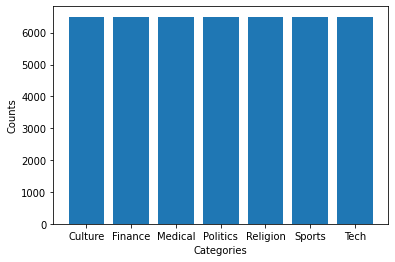

In [14]:
#visualize the distribution of dataset 
unique, counts = np.unique(data['label'], return_counts=True)
plt.bar(unique, counts, align='center')
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

In [15]:
data.describe()

,text,label
count,45500,45500
unique,45485,7
top,إعداد: محمد صالح القرق دخل على رسول الله- صلى ...,Politics
freq,3,6500


**--->We found that Khaleej dataset is a balanced dataset, that is good for deep learning models.**

# **Data Pre-Processing**

In this part, we clean the data by removing Emoji, Arabic diacritics, and special characters, then we finish this part with tokenization, and lemmatization.

## **Data Cleaning & Tokenization**

In [16]:
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [17]:
def removeEmoji(dataset_text_row):
    #Remove Emoji Exemple code :
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               "]+", flags=re.UNICODE)
    result = emoji_pattern.sub(r'',dataset_text_row)
    return result

def removeDiacritics(dataset_text_row):
    arabic_diacritics = re.compile(""" ّ    | # Tashdid
                             َ    | # Fatha
                             ً    | # Tanwin Fath
                             ُ    | # Damma
                             ٌ    | # Tanwin Damm
                             ِ    | # Kasra
                             ٍ    | # Tanwin Kasr
                             ْ    | # Sukun
                             ـ     # Tatwil/Kashida
                         """, re.VERBOSE)
    result = re.sub(arabic_diacritics, '', dataset_text_row)
    return result

def remove_special_chars(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Remove punctuation and digits
    text = re.sub(r'[^\w\s]', '', text)
    # Remove English letters (if present)
    text = re.sub(r'[A-Za-z]', '', text)
    # Remove digits
    text = re.sub(r'\d+', '', text)
    # Remove extra spaces
    text = re.sub(r'\s+', ' ', text, flags=re.MULTILINE)
    return text


def removeStopwords(words):
    stop_words = set(stopwords.words('arabic'))
    result = [word for word in words if not word in stop_words]
    return result

def tokenization(dataset_text_row):
    tokens = word_tokenize(dataset_text_row)
    return tokens

def lemmatization(text):
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word) for word in text]
    return lemmas

In [18]:
data['cleaned_text'] = data['text'].apply(removeEmoji)
data['cleaned_text'] = data['cleaned_text'].apply(removeDiacritics)
data['cleaned_text'] = data['cleaned_text'].apply(remove_special_chars)
data['cleaned_text'] = data['cleaned_text'].apply(tokenization)
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: removeStopwords(x))
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: lemmatization(x))

print(data['cleaned_text'].head(20))

0     [قتل, عسكريين, جزائريين, وأصيب, بجروح, الاثنين...
1     [افتتح, عبدالله, سعيد, بن, سويف, سكرتير, إدارة...
2     [كشف, سوميت, نيهالاني, مدير, المبيعات, مؤشرات,...
3     [أبوظبيمحمد, علاونة, تحتاج, الثقافة, العربية, ...
4     [ضمن, الفعاليات, الشعرية, المعرض, قرأت, الشاعر...
5     [المسجد, مدرسة, الإسلام, الأولى, يتعلم, المسلم...
6     [أعلنت, هواوي, الشركة, المتخصصة, توفير, حلول, ...
7     [دبي, الخليج, ضمن, جهودها, لإحداث, الطفرة, الن...
8     [بناء, القيم, يمثل, الإنسان, السجايا, الحسنة, ...
9     [أبرمت, هيئة, كهرباء, ومياه, دبي, وشركة, سامسو...
10    [دبي, الخليج, أعلنت, هيئة, الشارقة, للاستثمار,...
11    [أكدت, والدة, اللاعب, البرتغالي, الدولي, كريست...
12    [لنكن, صرحاء, أنفسنا, عندما, نتحدث, الحلال, وا...
13    [دعت, الهيئة, الدائمة, المستقلة, لحقوق, الإنسا...
14    [حسم, تشلسي, حامل, اللقب, والمتصدر, موقعة, الق...
15    [الشارقة, الخليج, اختتمت, فعاليات, مهرجان, الف...
16    [أكد, الديوان, الملكي, البحريني, الأربعاء, أنه...
17    [البطولات, الأوروبية, المحليةاكتفى, روما, 

For the Lemmatization does not give a good result, but we use it because it is fast and doesn't take a long time.

In [19]:
data.to_csv('clean_data_khaleej.csv', index= False)

# **Data Encoder**


In [8]:
# !unzip clean_data_khaleej.zip

In [3]:
import pandas as pd

data = pd.read_csv('clean_data_khaleej.csv')

## **Label Encoding**

In [ ]:
from sklearn.preprocessing import LabelEncoder
from keras.utils.np_utils import to_categorical
import numpy as np

label_encoder = LabelEncoder()
label_encoder.fit(data['label'])
Y = label_encoder.fit_transform(data['label'])

# Converts the labels to a one-hot representation
N_CLASSES = np.max(Y) + 1
Y = to_categorical(Y, N_CLASSES)
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (45500, 7)


## **Tokenization and Padding of sequences**

In [7]:
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# initialize Tokenizer
tokenizer = Tokenizer(num_words=40000, lower=False)
tokenizer.fit_on_texts(data['cleaned_text'])
# print(data['cleaned_text'].head())
# convert texts to sequences
sequences = tokenizer.texts_to_sequences(data['cleaned_text'])

# pad sequences
X = pad_sequences(sequences, maxlen=500)
# print(data['cleaned_text'].head())
# print shape of X
print("Shape of X: ", X.shape)

Shape of X:  (45500, 500)


### *Glove*



> This method is working but it takes a long time to finish, for that we chose to use the pad of sequences above.



In [6]:
# from sklearn.feature_extraction.text import CountVectorizer
# import numpy as np
# def glove_embeding(text):

#     # Create a CountVectorizer object
#     vectorizer = CountVectorizer(lowercase=False)

#     # Fit the CountVectorizer on the text data
#     X = vectorizer.fit_transform([text])

#     # Create a dictionary to store the words and their respective indexes
#     word_index = vectorizer.vocabulary_

#     # Create a co-occurrence matrix
#     cooccurrence_matrix = X.T.dot(X)

#     # Define the dimensionality of the embeddings
#     embedding_dim = 3

#     # Initialize the embeddings randomly
#     embeddings = np.random.rand(len(word_index), embedding_dim)

#     # Train the embeddings using the GloVe algorithm
#     for epoch in range(100):
#         for word, index in word_index.items():
#             word_embedding = embeddings[index]
#             word_cooccurrence = cooccurrence_matrix[index].toarray()[0]
#             for j, cooccurrence in enumerate(word_cooccurrence):
#                 if cooccurrence > 0:
#                     context_embedding = embeddings[j]
#                     weight = cooccurrence / np.sqrt(np.sum(word_cooccurrence))
#                     delta = weight * (word_embedding - context_embedding)
#                     embeddings[index] -= 0.001 * delta
#                     # Get the numerical representations of the words in the text data
#     numerical_representations = embeddings[list(word_index.values())]
#     return numerical_representations

# X = data['cleaned_text'].apply(lambda x: glove_embeding(x))

# **Deep Learning Models**

In [1]:
# !pip install keras-tuner

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPooling1D, Flatten, Dropout,Input,GlobalAveragePooling1D
from keras.optimizers import Adam
from keras.models import Model
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.callbacks import EarlyStopping
from kerastuner.tuners import RandomSearch

print(tf.__version__)

2.11.0


<ipython-input-6-4b61e15f2472>:13: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch


## **Split The Dataset**


This code  splits the dataset into three sets: a training set, a validation set, and a test set.


*   training set = 80% of the original dataset.
*   test set = 12% of the original dataset
*   validation set = 8% of the original dataset.








In [ ]:
# split the dataset to trainning set and test set
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=42)
# split the test set to test set and validation set 
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.4, random_state=42)

## **Deep Learning Models Without Tuning**

### LSTM-CNN

In [ ]:
embedding_dim = 100
max_features = 40000
sequence_length = 500
max_length = 16
model = tf.keras.Sequential([
  Embedding(max_features + 1, embedding_dim,  trainable=False),
  Dropout(0.2),
  Conv1D(64, 5, activation='relu'),
  MaxPooling1D(pool_size=4),
  LSTM(64),
  Dense(N_CLASSES, activation='softmax')])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 100)         4000100   
                                                                 
 dropout (Dropout)           (None, None, 100)         0         
                                                                 
 conv1d (Conv1D)             (None, None, 64)          32064     
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 64)         0         
 )                                                               
                                                                 
 lstm (LSTM)                 (None, 64)                33024     
                                                                 
 dense (Dense)               (None, 7)                 455       
                                                        

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
epochs = 100
hist_lstm_cnn = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=8,
    epochs=epochs)

Epoch 1/100
4550/4550 [==============================] - 57s 10ms/step - loss: 1.9142 - accuracy: 0.1820 - val_loss: 1.8793 - val_accuracy: 0.2115
Epoch 2/100
4550/4550 [==============================] - 34s 8ms/step - loss: 1.8018 - accuracy: 0.2722 - val_loss: 1.7598 - val_accuracy: 0.3113
Epoch 3/100
4550/4550 [==============================] - 37s 8ms/step - loss: 1.7187 - accuracy: 0.3250 - val_loss: 1.6362 - val_accuracy: 0.3538
Epoch 4/100
4550/4550 [==============================] - 36s 8ms/step - loss: 1.5799 - accuracy: 0.3726 - val_loss: 1.4936 - val_accuracy: 0.3940
Epoch 5/100
4550/4550 [==============================] - 36s 8ms/step - loss: 1.5097 - accuracy: 0.3964 - val_loss: 1.5002 - val_accuracy: 0.3931
Epoch 6/100
4550/4550 [==============================] - 36s 8ms/step - loss: 1.5907 - accuracy: 0.3698 - val_loss: 1.6845 - val_accuracy: 0.2959
Epoch 7/100
4550/4550 [==============================] - 35s 8ms/step - loss: 1.5508 - accuracy: 0.3852 - val_loss: 1.4131 

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

171/171 [==============================] - 2s 6ms/step - loss: 0.3233 - accuracy: 0.8907
Test loss: 0.3233332335948944
Test accuracy: 0.8906593322753906


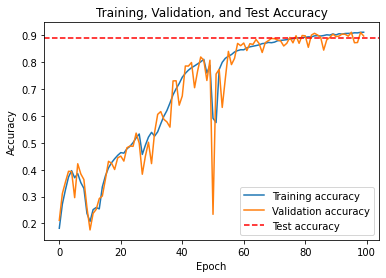

In [ ]:
# Plot the training history
train_acc = hist_lstm_cnn.history['accuracy']
val_acc = hist_lstm_cnn.history['val_accuracy']
test_acc = accuracy

plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.axhline(test_acc, color='red', linestyle='--', label='Test accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Result Comment :**
> As the final result of LSTM-CNN in the Arabic text classification Khaleej dataset, we have Test accuracy of 89.06% and Test loss of 0.3233, to get these results we used a batch of 8 and we trained the model 100 epochs.



### CNN


In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Flatten, Dense
embedding_dim = 50
max_length = 500
max_features = 40000
# define model
model = Sequential([
        Embedding(max_features+ 1, output_dim=embedding_dim, input_length=max_length, trainable=False),
        Conv1D(filters=128, kernel_size=3, activation='relu'),
        MaxPooling1D(pool_size=2),
        Flatten(),
        Dense(N_CLASSES, activation='softmax')
    ])
# compile model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
hist_cnn = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=20, batch_size=8)

Epoch 1/20
4550/4550 [==============================] - 26s 5ms/step - loss: 0.2366 - accuracy: 0.6452 - val_loss: 0.1692 - val_accuracy: 0.7940
Epoch 2/20
4550/4550 [==============================] - 22s 5ms/step - loss: 0.1134 - accuracy: 0.8854 - val_loss: 0.1148 - val_accuracy: 0.8857
Epoch 3/20
4550/4550 [==============================] - 16s 3ms/step - loss: 0.0674 - accuracy: 0.9455 - val_loss: 0.1085 - val_accuracy: 0.8879
Epoch 4/20
4550/4550 [==============================] - 16s 3ms/step - loss: 0.0430 - accuracy: 0.9726 - val_loss: 0.0985 - val_accuracy: 0.9008
Epoch 5/20
4550/4550 [==============================] - 17s 4ms/step - loss: 0.0282 - accuracy: 0.9860 - val_loss: 0.1205 - val_accuracy: 0.8934
Epoch 6/20
4550/4550 [==============================] - 16s 4ms/step - loss: 0.0190 - accuracy: 0.9929 - val_loss: 0.1113 - val_accuracy: 0.9052
Epoch 7/20
4550/4550 [==============================] - 17s 4ms/step - loss: 0.0130 - accuracy: 0.9965 - val_loss: 0.1241 - val_ac

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

171/171 [==============================] - 1s 3ms/step - loss: 0.2086 - accuracy: 0.8958
Test loss: 0.20856021344661713
Test accuracy: 0.8957875370979309


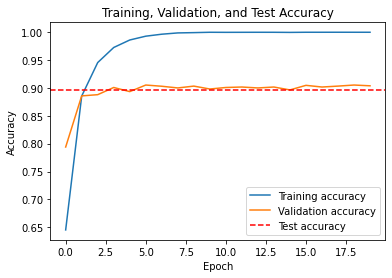

In [ ]:
# Plot the training history
train_acc = hist_cnn.history['accuracy']
val_acc = hist_cnn.history['val_accuracy']
test_acc = accuracy

plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.axhline(test_acc, color='red', linestyle='--', label='Test accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Result Comment :**
> As the final result of CNN in the Arabic text classification Khaleej dataset, we have Test accuracy of 89.57% and Test loss of 0.2085%, to get these results we used a batch of 8 and we trained the model 10 epochs.

### LSTM

In [ ]:
embedding_dim = 50
max_length = 16
MAX_NB_WORDS = 40000
model = tf.keras.Sequential([
  Embedding(MAX_NB_WORDS, embedding_dim,  trainable=False),
  LSTM(64),
  Dense(N_CLASSES, activation='softmax')])

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 50)          2000000   
                                                                 
 lstm_1 (LSTM)               (None, 64)                29440     
                                                                 
 dense_2 (Dense)             (None, 7)                 455       
                                                                 
Total params: 2,029,895
Trainable params: 29,895
Non-trainable params: 2,000,000
_________________________________________________________________


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Train the model on the train set
epochs = 100
hist_lstm = model.fit(
    X_train,y_train,
    batch_size=64,
    validation_data= (X_val, y_val),
    epochs=epochs)

Epoch 1/100
569/569 [==============================] - 15s 20ms/step - loss: 1.8839 - accuracy: 0.2292 - val_loss: 1.8181 - val_accuracy: 0.2755
Epoch 2/100
569/569 [==============================] - 10s 17ms/step - loss: 1.8162 - accuracy: 0.2864 - val_loss: 1.7858 - val_accuracy: 0.2775
Epoch 3/100
569/569 [==============================] - 10s 18ms/step - loss: 1.7057 - accuracy: 0.3266 - val_loss: 1.6136 - val_accuracy: 0.4181
Epoch 4/100
569/569 [==============================] - 10s 18ms/step - loss: 1.7217 - accuracy: 0.3314 - val_loss: 1.6335 - val_accuracy: 0.3681
Epoch 5/100
569/569 [==============================] - 11s 19ms/step - loss: 1.5625 - accuracy: 0.3872 - val_loss: 1.5293 - val_accuracy: 0.3640
Epoch 6/100
569/569 [==============================] - 10s 18ms/step - loss: 1.6468 - accuracy: 0.3615 - val_loss: 1.8081 - val_accuracy: 0.3071
Epoch 7/100
569/569 [==============================] - 10s 18ms/step - loss: 1.6701 - accuracy: 0.3507 - val_loss: 1.7960 - val_ac

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

171/171 [==============================] - 2s 12ms/step - loss: 0.3008 - accuracy: 0.9046
Test loss: 0.30077868700027466
Test accuracy: 0.9045787453651428


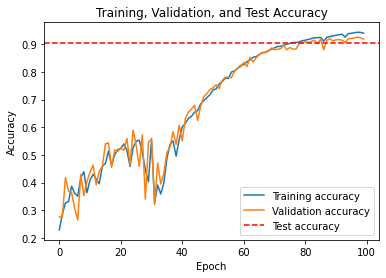

In [ ]:
# Plot the training history
train_acc = hist_lstm.history['accuracy']
val_acc = hist_lstm.history['val_accuracy']
test_acc = accuracy

plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.axhline(test_acc, color='red', linestyle='--', label='Test accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Result Comment :**
> As the final result of LSTM-CNN in the Arabic text classification Khaleej dataset, we have Test accuracy of 90.45% and Test loss of  0.3008, to get these results we used a batch of 8 and we trained the model 100 epochs.



### DNN

In [ ]:
from keras.layers import Dense, Input, Flatten
from keras.layers import GlobalAveragePooling1D, Embedding
from keras.models import Model

EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH = 500
MAX_NB_WORDS = 40000
# input: a sequence of MAX_SEQUENCE_LENGTH integers
sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')

embedding_layer = Embedding(MAX_NB_WORDS, EMBEDDING_DIM,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)

embedded_sequences = embedding_layer(sequence_input)

average = GlobalAveragePooling1D()(embedded_sequences)
predictions = Dense(N_CLASSES, activation='softmax')(average)

model = Model(sequence_input, predictions)
model.compile(loss='categorical_crossentropy',
              optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 500)]             0         
                                                                 
 embedding_4 (Embedding)     (None, 500, 50)           2000000   
                                                                 
 global_average_pooling1d_1   (None, 50)               0         
 (GlobalAveragePooling1D)                                        
                                                                 
 dense_4 (Dense)             (None, 7)                 357       
                                                                 
Total params: 2,000,357
Trainable params: 2,000,357
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model on the train set
hist_dnn = model.fit(X_train, y_train, validation_data= (X_val, y_val), epochs=10, batch_size=64)

Epoch 1/10
569/569 [==============================] - 61s 101ms/step - loss: 1.4016 - accuracy: 0.7484 - val_loss: 0.8403 - val_accuracy: 0.9055
Epoch 2/10
569/569 [==============================] - 41s 72ms/step - loss: 0.5737 - accuracy: 0.9347 - val_loss: 0.4046 - val_accuracy: 0.9484
Epoch 3/10
569/569 [==============================] - 30s 54ms/step - loss: 0.3141 - accuracy: 0.9614 - val_loss: 0.2643 - val_accuracy: 0.9621
Epoch 4/10
569/569 [==============================] - 26s 45ms/step - loss: 0.2126 - accuracy: 0.9724 - val_loss: 0.1994 - val_accuracy: 0.9670
Epoch 5/10
569/569 [==============================] - 19s 34ms/step - loss: 0.1591 - accuracy: 0.9782 - val_loss: 0.1651 - val_accuracy: 0.9717
Epoch 6/10
569/569 [==============================] - 15s 26ms/step - loss: 0.1254 - accuracy: 0.9823 - val_loss: 0.1425 - val_accuracy: 0.9706
Epoch 7/10
569/569 [==============================] - 13s 24ms/step - loss: 0.1020 - accuracy: 0.9851 - val_loss: 0.1280 - val_accuracy

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

171/171 [==============================] - 1s 4ms/step - loss: 0.1283 - accuracy: 0.9729
Test loss: 0.1282920241355896
Test accuracy: 0.9728937745094299


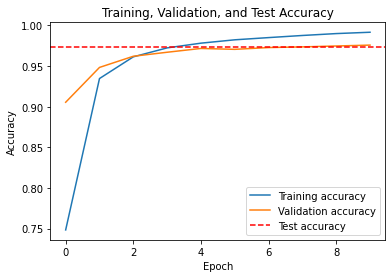

In [ ]:
# Plot the training history
train_acc = hist_dnn.history['accuracy']
val_acc = hist_dnn.history['val_accuracy']
test_acc = accuracy

plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.axhline(test_acc, color='red', linestyle='--', label='Test accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Result Comment :**

> As the final result of DNN in the Arabic text classification with Khaleej dataset, we have Test accuracy of 97.29% and Test loss of 0.1283, to get these results we used a batch of 64 and we trained the model 10 epochs.

⟹**This is the model that give best result with a few nubmer of epochs.**



## **Deep Learning Models With Tuning**



### LSTM-CNN


In [ ]:
# Define the model-building function
def build_model(hp):
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=512, step=32)
    filters = hp.Int('filters', min_value=64, max_value=256, step=32)
    kernel_size = hp.Int('kernel_size', min_value=3, max_value=7, step=2)
    lstm_units = hp.Int('lstm_units', min_value=32 , max_value=128, step=32)
    max_features = hp.Int('max_features', min_value=10000 , max_value=50000, step=10000)
    model = Sequential([
        Embedding(max_features + 1, hp['embedding_dim'], trainable=False),
        Dropout(0.2),
        Conv1D(hp['filters'], hp['kernel_size'], activation='relu'),
        MaxPooling1D(pool_size=4),
        LSTM(hp['lstm_units']),
        Dense(N_CLASSES, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model

In [ ]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='lstm_cnn_tuner_results',
    project_name='lstm_cnn_tuning'
)


In [ ]:
# Perform the hyperparameter search
tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=20
)

Trial 10 Complete [00h 03m 25s]
val_accuracy: 0.4263736307621002

Best val_accuracy So Far: 0.7991757988929749
Total elapsed time: 00h 40m 39s


In [ ]:
# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps)

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
hist_lstm_cnn_tuner = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=100
)


Best hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f64a04c30a0>
Epoch 1/100
569/569 [==============================] - 25s 37ms/step - loss: 1.9449 - accuracy: 0.1532 - val_loss: 1.9430 - val_accuracy: 0.1923
Epoch 2/100
569/569 [==============================] - 17s 30ms/step - loss: 1.9419 - accuracy: 0.2046 - val_loss: 1.9403 - val_accuracy: 0.2621
Epoch 3/100
569/569 [==============================] - 17s 29ms/step - loss: 1.9381 - accuracy: 0.2336 - val_loss: 1.9363 - val_accuracy: 0.2379
Epoch 4/100
569/569 [==============================] - 16s 29ms/step - loss: 1.9319 - accuracy: 0.2705 - val_loss: 1.9280 - val_accuracy: 0.3451
Epoch 5/100
569/569 [==============================] - 17s 30ms/step - loss: 1.8822 - accuracy: 0.3130 - val_loss: 1.7973 - val_accuracy: 0.3470
Epoch 6/100
569/569 [==============================] - 17s 31ms/step - loss: 1.7686 - accuracy: 0.3400 - val_loss: 1.7086 - val_accuracy: 0.3604
Epoch 7/100
56

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

171/171 [==============================] - 2s 9ms/step - loss: 0.2053 - accuracy: 0.9412
Test loss: 0.2053181231021881
Test accuracy: 0.9412087798118591


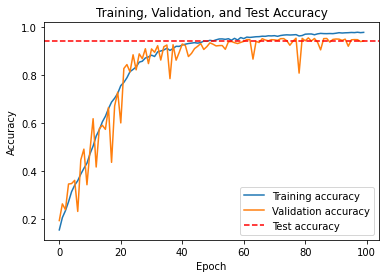

In [ ]:
# Plot the training history
train_acc = hist_lstm_cnn_tuner.history['accuracy']
val_acc = hist_lstm_cnn_tuner.history['val_accuracy']
test_acc = accuracy

plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.axhline(test_acc, color='red', linestyle='--', label='Test accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Result Comment :**

> As the final result of LSTM-CNN in the Arabic text classification, we have Test accuracy of 94.12% and Test loss of 20.53, to get these results we used a batch of 64, we trained the model 100 epochs, and the search for hyperparameter take 10 as max number of trials.

### CNN

In [ ]:
# Define the model-building function
def build_model(hp):
    MAX_SEQUENCE_LENGTH = 500
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=512, step=32)
    filters = hp.Int('filters', min_value=64, max_value=256, step=32)
    kernel_size = hp.Int('kernel_size', min_value=3, max_value=7, step=2)
    max_features = hp.Int('max_features', min_value=10000 , max_value=50000, step=10000)
    model = Sequential([
        Embedding(max_features + 1, hp['embedding_dim'], input_shape=(MAX_SEQUENCE_LENGTH,), trainable=False),
        Dropout(0.2),
        Conv1D(hp['filters'], hp['kernel_size'], activation='relu'),
        MaxPooling1D(pool_size=4),
        Flatten(),
        Dense(N_CLASSES, activation='softmax')
    ])
    model.compile(loss='categorical_crossentropy', optimizer='SGD', metrics=['accuracy'])
    return model

In [ ]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='cnn_tuner_results',
    project_name='cnn_tuning'
)

In [ ]:
# Perform the hyperparameter search
tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=20
)

Trial 10 Complete [00h 04m 49s]
val_accuracy: 0.7590659260749817

Best val_accuracy So Far: 0.7857142686843872
Total elapsed time: 00h 38m 23s


In [ ]:
# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps)

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
hist_cnn_tuner = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=100
)

Best hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7fca505f12e0>
Epoch 1/100
569/569 [==============================] - 13s 21ms/step - loss: 1.8325 - accuracy: 0.2643 - val_loss: 1.7858 - val_accuracy: 0.2863
Epoch 2/100
569/569 [==============================] - 12s 21ms/step - loss: 1.7774 - accuracy: 0.2902 - val_loss: 1.7668 - val_accuracy: 0.2912
Epoch 3/100
569/569 [==============================] - 12s 21ms/step - loss: 1.7603 - accuracy: 0.3042 - val_loss: 1.7545 - val_accuracy: 0.3179
Epoch 4/100
569/569 [==============================] - 12s 21ms/step - loss: 1.7390 - accuracy: 0.3251 - val_loss: 1.7278 - val_accuracy: 0.3324
Epoch 5/100
569/569 [==============================] - 12s 21ms/step - loss: 1.7054 - accuracy: 0.3456 - val_loss: 1.6875 - val_accuracy: 0.3599
Epoch 6/100
569/569 [==============================] - 12s 21ms/step - loss: 1.6561 - accuracy: 0.3693 - val_loss: 1.6335 - val_accuracy: 0.3734
Epoch 7/100
56

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

171/171 [==============================] - 1s 6ms/step - loss: 0.2210 - accuracy: 0.9324
Test loss: 0.22095610201358795
Test accuracy: 0.9324175715446472


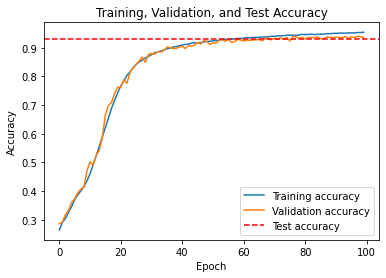

In [ ]:
# Plot the training history
train_acc = hist_cnn_tuner.history['accuracy']
val_acc = hist_cnn_tuner.history['val_accuracy']
test_acc = accuracy

plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.axhline(test_acc, color='red', linestyle='--', label='Test accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Result Comment :**

> As the final result of CNN in the Arabic text classification, we have Test accuracy of 93.24% and Test loss of 22.10%, to get these results we used a batch of 64, we trained the model 100 epochs, and the search for hyperparameter take 10 as max number of trials.

### DNN

In [ ]:
def build_model(hp):
    # Define the hyperparameters
    embedding_dim = hp.Int('embedding_dim', min_value=32, max_value=512, step=32)
    max_features = hp.Int('max_features', min_value=10000 , max_value=50000, step=10000)
    MAX_SEQUENCE_LENGTH = 500
    # Define the model architecture
    sequence_input = Input(shape=(MAX_SEQUENCE_LENGTH,), dtype='int32')
    embedding_layer = Embedding(max_features, embedding_dim,
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=True)
    embedded_sequences = embedding_layer(sequence_input)
    average = GlobalAveragePooling1D()(embedded_sequences)
    predictions = Dense(N_CLASSES, activation='softmax')(average)
    model = Model(sequence_input, predictions)

    # Compile the model
    model.compile(loss='categorical_crossentropy',
                  optimizer='adam', metrics=['accuracy'])

    return model

In [ ]:
# Instantiate the tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=10,
    directory='dnn_tuner_results',
    project_name='dnn_tuning'
)

In [ ]:
# Perform the hyperparameter search
tuner.search(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=10
)

Trial 10 Complete [00h 06m 23s]
val_accuracy: 0.9785714149475098

Best val_accuracy So Far: 0.980494499206543
Total elapsed time: 00h 18m 13s


In [ ]:
# Print the best hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print("Best hyperparameters:", best_hps)

# Build the model with the best hyperparameters and train it
model = tuner.hypermodel.build(best_hps)
hist_dnn_tuner = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    batch_size=64,
    epochs=10
)

Best hyperparameters: <keras_tuner.engine.hyperparameters.hyperparameters.HyperParameters object at 0x7f64d615f520>
Epoch 1/10
569/569 [==============================] - 85s 147ms/step - loss: 0.9504 - accuracy: 0.8405 - val_loss: 0.3585 - val_accuracy: 0.9481
Epoch 2/10
569/569 [==============================] - 58s 101ms/step - loss: 0.2400 - accuracy: 0.9669 - val_loss: 0.1841 - val_accuracy: 0.9695
Epoch 3/10
569/569 [==============================] - 45s 79ms/step - loss: 0.1361 - accuracy: 0.9788 - val_loss: 0.1363 - val_accuracy: 0.9728
Epoch 4/10
569/569 [==============================] - 38s 66ms/step - loss: 0.0928 - accuracy: 0.9857 - val_loss: 0.1155 - val_accuracy: 0.9736
Epoch 5/10
569/569 [==============================] - 28s 49ms/step - loss: 0.0671 - accuracy: 0.9899 - val_loss: 0.1048 - val_accuracy: 0.9755
Epoch 6/10
569/569 [==============================] - 23s 40ms/step - loss: 0.0491 - accuracy: 0.9932 - val_loss: 0.0998 - val_accuracy: 0.9783
Epoch 7/10
569/569

In [ ]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print("Test loss:", loss)
print("Test accuracy:", accuracy)

171/171 [==============================] - 1s 3ms/step - loss: 0.1189 - accuracy: 0.9742
Test loss: 0.11891770362854004
Test accuracy: 0.9741758108139038


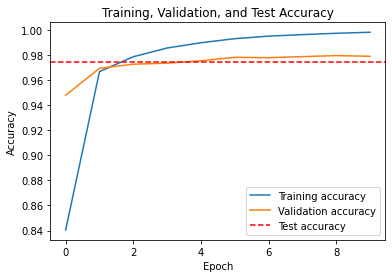

In [ ]:
# Plot the training history
train_acc = hist_dnn_tuner.history['accuracy']
val_acc = hist_dnn_tuner.history['val_accuracy']
test_acc = accuracy

plt.plot(train_acc, label='Training accuracy')
plt.plot(val_acc, label='Validation accuracy')
plt.axhline(test_acc, color='red', linestyle='--', label='Test accuracy')
plt.title('Training, Validation, and Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

**Result Comment :**

> As the final result of DNN in the Arabic text classification, we have Test accuracy of 97.42% and Test loss of 11.89%, to get these results we used a batch of 64, we trained the model 10 epochs, and the search for hyperparameter take 10 as max number of trials.

⟹**This is the model that give best result with a few nubmer of epochs.**

# **Conclusion**

In conclusion, the Deep Neural Network (DNN) model is the best model that can be used for Arabic text classification,it is achieved an impressive Test accuracy of 97.42% and Test loss of 0.1189. The model was trained for 10 epochs using a batch size of 64, and hyperparameter tuning was performed with a maximum of 10 trials. This DNN model performed exceptionally well, with only a few epochs required to achieve the best results.